## Imports

In [6]:
#Python3.10
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from dataretrieval import nwis, utils, codes

c:\Users\alekh\AppData\Local\Programs\Python\Python310\lib\site-packages\dataretrieval\nadp.py:44: UserWarning: GDAL not installed. Some functions will not work.
  warnings.warn('GDAL not installed. Some functions will not work.')


## Inputs

In [29]:
# 11447650 -- Sacramento River Basin
# 11303500 -- San Joaquin-Tulare Basin

SITE_NO = '11447650'
STATE_CODE = 'ca'
START_DATE = '1970-01-01'
END_DATE = '2014-01-01'
SERVICE = 'dv'


# 00060 -- Discharge
# 00010 -- Temperature
PARAM_CODE = '00060'

# ft^3 -> km^3
CUBIC_FT_KM_FACTOR = 0.0000000000283168466
# Seconds per year
SEC_PER_YEAR = 31536000 

## Data Retrieval<br>
<p>This is using average cubic feet per second discharge per year</p> 

In [16]:
df = nwis.get_stats(sites=SITE_NO, parameterCD=PARAM_CODE, statReportType='annual')

print("Retrieved " + str(len(df[0])) + " data values.")

# Removing metadata
df = pd.DataFrame(df[0])

# Scale 'mean_va' from feet per second to feet per year
df = df['mean_va'] * SEC_PER_YEAR

# Find the mean feet per year discharge
mean_annual_flow = df.mean()

# Calculate 90th percentile threshold
threshold = mean_annual_flow * 0.90

HMF_flow = [val - threshold for val in df if val > threshold]

total_flows_cfpy = sum(HMF_flow)
total_flows_ckpy = total_flows_cfpy * CUBIC_FT_KM_FACTOR


print(f'Total flow in CFPY: {total_flows_cfpy}')
print(f'Total flow in CKPY: {total_flows_ckpy}')

Retrieved 66 data values.
Total flow in CFPY: 10278299413963.63
Total flow in CKPY: 291.04902781407804


Here, looking at SRB using the post-impairment record from 1970-2014, and daily average discharge

In [45]:
df = nwis.get_record(sites=SITE_NO, service=SERVICE, parameterCD=PARAM_CODE, start=START_DATE, end=END_DATE)
df = df.reset_index()

# Convert to annual flow
df = pd.DataFrame(df['00060_Mean'] * 365)
min_annual_flow = df.min()
max_annual_flow = df.max()

# 90th percentile calculation
threshold_90 = min_annual_flow + ((max_annual_flow - min_annual_flow) * 0.90)
threshold_90 = float(threshold_90.iloc[0])

hmf_series = df[df['00060_Mean'] > threshold_90]['00060_Mean'] - threshold_90
total_hmf_flow = hmf_series.sum()
print(f'Total flow in CKPY: {total_hmf_flow * CUBIC_FT_KM_FACTOR}')


Total flow in CKPY: 0.00036707057455463504


## Plotting

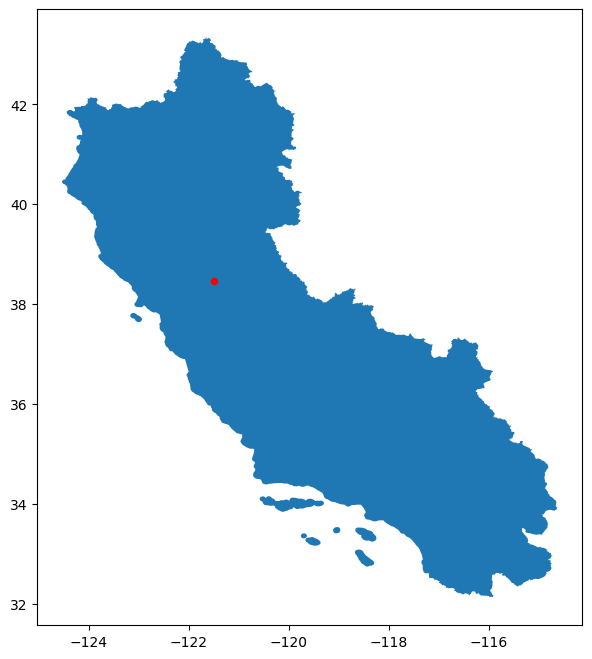

In [32]:
import geopandas as gpd
from shapely.geometry import Point

shape = gpd.read_file('ShapeFiles/CA/Shape/WBDHU2.shp')

df = nwis.get_record(sites=SITE_NO, service='site')
lat = [df['dec_lat_va'].iloc[0]]
long = [df['dec_long_va'].iloc[0]]

fig, ax = plt.subplots(figsize=(8, 8))
shape.plot(ax=ax)
geo = [Point(xy) for xy in zip(long, lat)]
geo_df = gpd.GeoDataFrame(geometry=geo)
plot = geo_df.plot(ax=ax, markersize=75, color='red', marker='.', label='CA')
plt.show()